# Exercise 8 - Conjoint Analysis (20 Points)

In this exercise you will work mostly on your own. You will have to read in the lectures script and think about own measures of quality.

In the event of a persistent problem, do not hesitate to contact the course instructors under
- paul.kahlmeyer@uni-jena.de

### Submission

- Deadline of submission:
        x.y.z
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=18310)

# The Dataset

In this exercise we will use preprocessed [statistics of Bundesliga clubs](https://www.whoscored.com/Regions/81/Tournaments/3/Seasons/6902/Stages/15243/TeamStatistics/Germany-Bundesliga-2017-2018) to predict their ranking in the table. Each dataset has the following attributes:

- `Team`: team name
- `Shots pg`: average shots on opponent goal per game
- `Yellow cards`: number of yellow cards
- `Red cards`: number of red cards
- `Possession%`: average ball possession percentage per game
- `Pass%`: average percentage of sucessful passes
- `AerialsWon`: average number of aerial duels won per game
- `Rank`: rank in the table

Each of these attributes was discretized into 3 categories based on the range of values for the season:

- 0: lower third of season range
- 1: central third of season range
- 2: upper third of season range

### Task 1 (1 Point)

Load and inspect the dataset for the season 2017/2018 stored in `buli_1718.csv`.

In [1]:
# TODO: load season 2017/2018 dataset
import pandas as pd
df = pd.read_csv('buli_1718.csv')
df.head()

,Team,Shots pg,Yellow cards,Red cards,Possession%,Pass%,AerialsWon,Rank
0,Bayern Munich,2,0,0,2,2,0,1
1,Freiburg,0,0,2,0,0,2,15
2,VfB Stuttgart,0,1,0,0,0,1,7
3,Borussia M.Gladbach,1,0,0,1,1,0,9
4,Hoffenheim,1,2,0,0,1,0,3


In conjoint analysis the dataset has to be a series of choice tasks
\begin{equation}
((a^{(i)},b^{(i)}),y^{(i)})\,,
\end{equation}
where $y^{(i)}=1$, if $a$ has been chosen and $-1$ otherwise.

We can transform our dataset into choice tasks if we consider $a$ and $b$ as the properties of teams and choose the team with the higher ranking. Of course $a$ and $b$ are **not** containing the ranking themselves.

### Task 2 (2 Points)

Translate the dataset into a set of choice tasks.

In [2]:
# TODO: translate into dataset ((a,b),y)
import numpy as np
rankings = np.array(df['Rank'])
items = np.stack([np.array(df[k]) for k in df.keys()[1:-1]]).T # select columns, stack them
nmb_cats = 3 # number of categories (low, medium, high)

options = []
choices = []
for i, (a, ranking_a) in enumerate(zip(items, rankings)):
    for j, (b, ranking_b) in enumerate(zip(items, rankings)):
        if i<j:
            # lower position -> better (higher rank in table)
            if ranking_a<ranking_b:
                y = 1
            else:
                y = -1
            options.append((a,b))
            choices.append(y)

In [3]:
k = 3
for (a,b),y in zip(options[:k],choices[:k]):
    print(f'Option a: {a}, Option b: {b}, Choice: {y}')

Option a: [2 0 0 2 2 0], Option b: [0 0 2 0 0 2], Choice: 1
Option a: [2 0 0 2 2 0], Option b: [0 1 0 0 0 1], Choice: 1
Option a: [2 0 0 2 2 0], Option b: [1 0 0 1 1 0], Choice: 1


In order to exploit the duality of points and planes, we have to translate the options $a$ and $b$ into the plane
\begin{equation}
n^{(i)} = \mathbb{1}_{a^{(i)}}-\mathbb{1}_{b^{(i)}}
\end{equation}

### Task 3 (2 Points)
Read in the lecture script (Chapter 21), how $\mathbb{1}_{a^{(i)}}$ is defined. 
Implement a function `vec`, that transforms $a$ into $\mathbb{1}_{a^{(i)}}$.

In [4]:
def vec(a):
    # TODO: translate item into vectorized form
    ret = []
    # for each category: one hot encoded vector
    for i, c in enumerate(a):
        tmp = np.zeros(nmb_cats)
        tmp[c] = 1
        ret.append(tmp)
    # append all vectors
    return np.concatenate(ret)

### Task 4 (1 Point)
Now use `vec` to translate $((a^{(i)},b^{(i)}),y^{(i)})$ into $(n^{(i)},y^{(i)})$

In [5]:
# TODO: translate options into planes
planes = np.stack([vec(a)-vec(b) for a,b in options])

# Estimation of partworth vector

Now we have a set of labeled hyperplanes and are looking for a value function, that can predict which hyperplane we choose. Our main assumption is, that this function is based on a vector of partworths $v$.

### Task 5 (2 Points)
Reread in the script, how the value function is defined and implement a version `value`, that takes an item $a$ from the dataset and a partworth vector $v$ as input and outputs the value of $a$.

In [6]:
def value(a, v):
    # TODO: implement value function
    return vec(a) @ v

Thanks to the duality of hyperplanes and points, we can interpret the hyperplanes $n^{(i)}$ as points and the partworth vector $v$ as a hyperplane. With this view, our problem of estimating $v$ reduces to a simple binary classification task.

### Task 6 (2 Points)

Estimate $v$ using any binary classificator you like. Read in the script, if there are special constraints to the classifier.

In [7]:
# TODO: use binary classificator
from sklearn.linear_model import SGDClassifier
regressor =  SGDClassifier(fit_intercept=False, random_state=0, learning_rate='adaptive', eta0=1e-1, verbose=0)
regressor.fit(planes, choices)
v = regressor.coef_.flatten()

### Task 7 (2 Points)
Implement a `predict` function, that takes two items and the partworth vector and outputs -1 or 1.

Test this function on the dataset and determine the accuracy. Tune your classifier to get a high accuracy.

In [8]:
def predict(a,b, v):
    # TODO: predict 1 or -1 
    v_a = value(a, v)
    v_b = value(b, v)
    return 2*(v_a>v_b)-1
    
# TODO: determine accuracy
preds = np.array([predict(a,b,v) for a,b in options])
test_acc = np.mean(choices == preds)
print(f'Accuracy: {test_acc}')

Accuracy: 0.8431372549019608


The estimated partworth vector contains information on the importance of the features on the table rank.

As an example, there are three entries in $v$, that correspond to `shots pg` being below average, average or above average in the season. We would expect above average to have the highest value among these three, because teams with more shots per game tend to score more goals and win more games.

### Task 8 (2 Points)
Visualize the information contained in the partworth vector. How do you interpret this information? Is everything as you would expect?

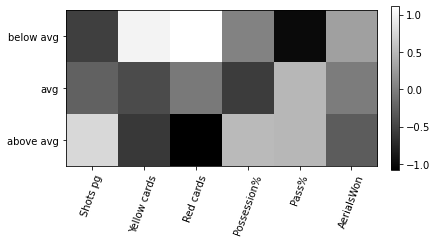

In [9]:
# TODO: visualize + interpret priorities set by v
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.imshow(v.reshape(6,nmb_cats).T, cmap='gray')
plt.xticks(ticks = np.arange(0,items.shape[1],1), labels = df.keys()[1:-1], rotation=70)
plt.yticks(ticks = np.arange(0,nmb_cats,1), labels = ['below avg', 'avg', 'above avg'])
plt.colorbar(fraction=0.03, pad=0.04)

# Prediction of table ranking

Besides getting an inside into the effect of certain attributes, we can also use the partworth vector to predict the ranking of other items.

### Task 9 (1 Point)

Load the dataset for the season 2018/2019 stored in `buli_1819.csv`.

In [10]:
# TODO: load season 2018/2019 dataset
df = pd.read_csv('buli_1819.csv')
df.head()

,Team,Shots pg,Yellow cards,Red cards,Possession%,Pass%,AerialsWon,Rank
0,Wolfsburg,0,2,0,1,1,1,6
1,Bayern Munich,2,0,1,2,2,0,1
2,Schalke 04,0,2,2,0,0,1,14
3,Hannover 96,0,1,2,0,0,1,17
4,Borussia M.Gladbach,1,0,0,1,2,0,5


### Task 10 (2 Points)

Print the table that you would predict with the partworth vector we estimated from the season 2017/2018.

Hint: If Bayern is somewhere on top and Nürnberg somewhere on the bottom, its a good rating ^^

In [11]:
# TODO: print predicted table
items = np.stack([np.array(df[k]) for k in df.keys()[1:-1]]).T
est_ranking = np.argsort([-value(x, v) for x in items])
df[:].loc[est_ranking]

,Team,Shots pg,Yellow cards,Red cards,Possession%,Pass%,AerialsWon,Rank
12,Bayer Leverkusen,1,0,0,2,2,0,4
1,Bayern Munich,2,0,1,2,2,0,1
4,Borussia M.Gladbach,1,0,0,1,2,0,5
11,Borussia Dortmund,0,0,1,2,2,0,2
13,Hoffenheim,2,2,1,1,1,0,9
0,Wolfsburg,0,2,0,1,1,1,6
9,Freiburg,0,1,1,0,1,0,13
8,Mainz 05,1,1,0,0,0,1,12
17,Augsburg,1,1,0,0,0,1,15
6,Werder Bremen,1,1,1,1,1,1,8


We saw, that $v$ implies an order (ranking) among the items, which results in a table prediction.

### Task 11 (3 Points)

Define some measure of quality to quantify or good the prediction of the table is compared to the true ranking in the table.

In [12]:
# TODO: quantify quality of predicted ranking compared to true ranking
def rank(X):
    ranks = np.zeros(X.shape[0])
    sort_idx = np.argsort([-value(a, v) for a in X])
    for ranking, item_idx in enumerate(sort_idx):
        ranks[item_idx] = ranking+1
    return ranks.astype(np.uint8)


rankings = np.array(df['Rank'])
measure = np.mean(abs(rankings-rank(items)))
print(f'Mean distance to true rank: {measure}')
measure = np.median(abs(rankings-rank(items)))
print(f'Median distance to true rank: {measure}')
measure = np.max(abs(rankings-rank(items)))
print(f'Maximum distance to true rank: {measure}')

Mean distance to true rank: 3.2222222222222223
Median distance to true rank: 2.5
Maximum distance to true rank: 8
